# Selection of SR correlation from cross-validation datat

This workbook ranks and selects the expressions discovered for the bulk modulus correlation.

In [2]:
# import packages
import numpy as np
import pandas as pd
import workflows as wf
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.model_selection import KFold
import sklearn.metrics as skmetrics 
from itertools import permutations
import ast
from collections import Counter
import runSR as sr

In [3]:
# define functions
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False


def eqn_token(formula):
    from io import StringIO
    import tokenize

    output = [token[1] for token in tokenize.generate_tokens(StringIO(formula).readline) if token[1]]
    output = np.array(output)
    return output

def flatten(l):
    return [item for sublist in l for item in sublist]

# RETURN SORTED LIST OF TERMS ONLY, REMOVING THE COEFFICIENTS
def list_terms(eqn1):
    eqn1_token = eqn_token(eqn1)
    lenlist = [len(e) for e in eqn_token(eqn1)] #Number of digits/letters in each term
    coeff_inds = np.where([i > 10 for i in lenlist])[0].tolist() #Indices of terms with 10+ (coeff digits)
    coeffs = eqn1_token[coeff_inds]

    for coeff in coeffs:
        eqn1 = eqn1.replace(coeff,'K')
        
    if eqn1[0]== '-': #get rid of first negative term
        eqn1 = eqn1[1:]
        
    eqn1 = eqn1.replace(' - K','+K')
    eqn1 = eqn1.replace(' + K','+K')
    
    eqn1 = eqn1.split("+K*")
    eqn1 = [eqni.split("+K") for eqni in eqn1]
    eqn1 = flatten(eqn1)
    eqn1 = [eqni.split("K") for eqni in eqn1]
    eqn1 = flatten(eqn1)
    try:
        while True:
            eqn1.remove('')
    except ValueError:
        pass
    for i,eqni in enumerate(eqn1):
        if eqni[0] == '*':
            eqn1[0] = eqni[1:]
    eqn1 = sorted(eqn1)
    
    return eqn1
    

In [6]:
# LOAD SR KFOLD RESULTS
#=========================================
file = 'SR_Kfold_BulkModulus_Results.csv'
df = pd.read_csv(file)

# ONLY INLCUDE TERMS WITH ALL [T,r,m]
#=========================================
df = df[df['eqn'].str.contains('m') & df['eqn'].str.contains('T') & df['eqn'].str.contains('r')]
df = df.reset_index(drop=True)

# ADD N_Terms TO DF
#=========================================
N_terms = []
for eqn in df.eqn:
    lenlist = [len(e) for e in eqn_token(eqn)]
    N = sum(i > 10 for i in lenlist) #THRESHOLD FOR EACH COEFFICIENT IS 10 SIGFIGS
    N_terms.append(N)
df['Nterms'] = N_terms

In [48]:
df.head(1)

,Unnamed: 0,kfold,exp,feats,eqn,rmse_test,r2_test,rmse_train,r2_train,ytrain_real,ytrain_hat,ytest_real,ytest_hat,Nterms
0,0,0,['sqrt'],1,-0.012011687879527975*T + 0.17071992622710416*...,0.039575,0.994409,0.044448,0.990465,[0 1.578484\n1 1.552619\n2 1.52...,"[array([1.6229102 , 1.60163404, 1.58023263, 1....",[0 1.484068\n1 1.322982\n2 1.26450...,"[array([1.53759753, 1.37629728, 1.31157828, 1....",4


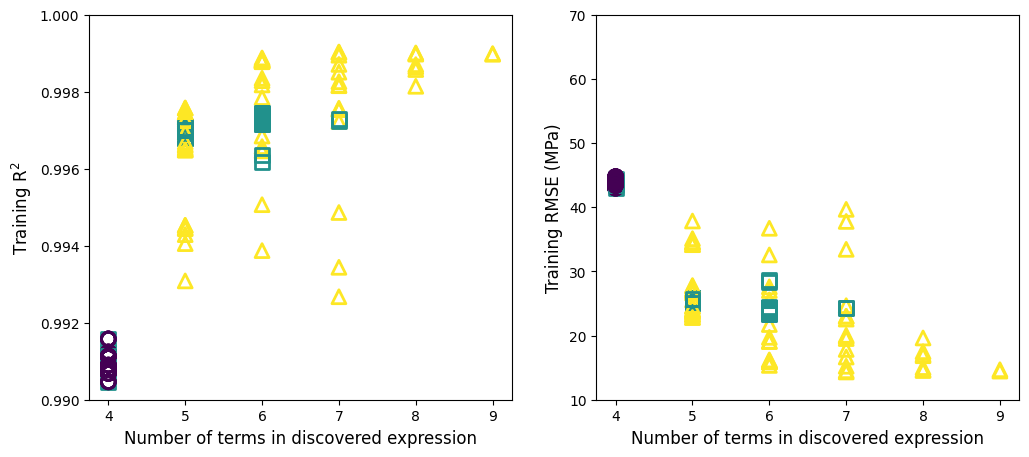

In [80]:
# Goodness of fit for Training Set
#=========================================

viridis = cm.get_cmap('viridis',3)
colors = viridis(range(5))
shapes = ["s","^","o"]

# fig, ax = plt.subplots(1,1,figsize=(7,5))
fig, ax = plt.subplots(1,2,figsize=(12,5))
for i in range(len(df)):
    feat = df.feats[i]
    n_exp = len(ast.literal_eval(df.exp[i]))
    n_terms = df.Nterms[i] 
    y2 = df.rmse_train[i]
    y = df.r2_train[i]
    ax[0].scatter(n_terms, y, s=100, marker=shapes[feat-2],facecolors='none',edgecolors=colors[feat-1],linewidths=2,label=feat)
    ax[1].scatter(n_terms, y2*1000, s=100, marker=shapes[feat-2],facecolors='none',edgecolors=colors[feat-1],linewidths=2,label=feat)
ax[0].set_ylabel('Training R$^2$', fontsize=12)
ax[0].set_xlabel('Number of terms in discovered expression', fontsize=12)
ax[0].set_ylim([0.99,1])

ax[1].set_ylabel('Training RMSE (MPa)', fontsize=12)
ax[1].set_xlabel('Number of terms in discovered expression', fontsize=12)
ax[1].set_ylim([10,70])
plt.show()
# fig.savefig('training.png')

<Figure size 640x480 with 0 Axes>

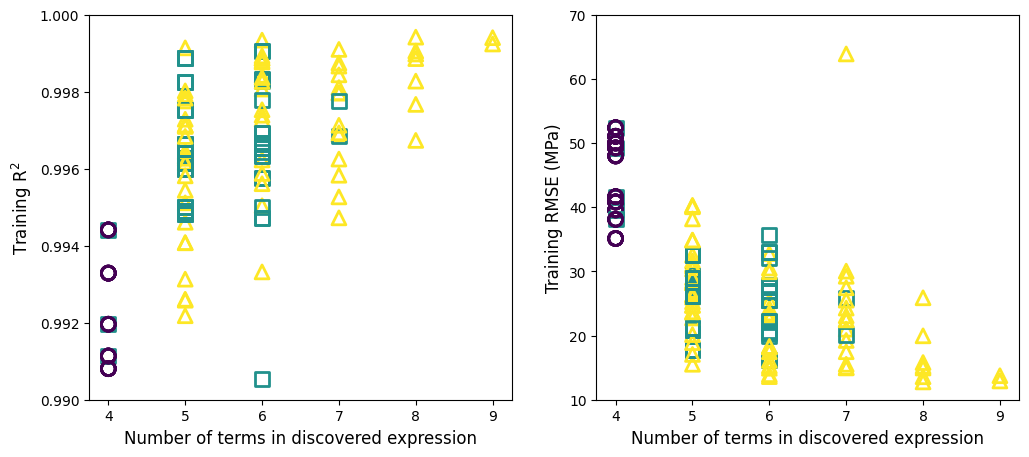

In [79]:
# Goodness of fit for Test Set
#=========================================

viridis = cm.get_cmap('viridis',3)
colors = viridis(range(5))
shapes = ["s","^","o"]

# fig, ax = plt.subplots(1,1,figsize=(7,5))
fig, ax = plt.subplots(1,2,figsize=(12,5))
for i in range(len(df)):
    feat = df.feats[i]
    n_exp = len(ast.literal_eval(df.exp[i]))
    n_terms = df.Nterms[i] 
    y2 = df.rmse_test[i]
    y = df.r2_test[i]
    ax[0].scatter(n_terms, y, s=100, marker=shapes[feat-2],facecolors='none',edgecolors=colors[feat-1],linewidths=2,label=feat)
    ax[1].scatter(n_terms, y2*1000, s=100, marker=shapes[feat-2],facecolors='none',edgecolors=colors[feat-1],linewidths=2,label=feat)
ax[0].set_ylabel('Training R$^2$', fontsize=12)
ax[0].set_xlabel('Number of terms in discovered expression', fontsize=12)
ax[0].set_ylim([0.99,1])

ax[1].set_ylabel('Training RMSE (MPa)', fontsize=12)
ax[1].set_xlabel('Number of terms in discovered expression', fontsize=12)
ax[1].set_ylim([10,70])
plt.show()
# fig.savefig('test.png')

In [59]:
# EQUATION EXPRESSION TERM MATCHING
#=========================================
term_str = []
term_list = []
for eqn in df.eqn:
    tlist = list_terms(eqn)
    tstr = ' , '.join(tlist)
    term_str.append(tstr)
    term_list.append(tlist)

df['term_str'] = term_str
df['term_list'] = term_list

In [61]:
# GENERATE RANKING TABLE OF TERMS
#=========================================
letter_counts = Counter(df['term_str'])
df_terms = pd.DataFrame.from_dict(letter_counts, orient='index')
df_terms = df_terms.sort_values(by=[0],ascending=False)
df_terms = df_terms.rename(columns={0: 'occur'})

term_strs = df_terms.index.tolist()
r2_test_array = []
r2_train_array = []
rmse_test_array = []
rmse_train_array = []
Nterms = []

for term_str in term_strs:
#     print(term_str)
    df_res = df[(df['term_str']==term_str)]
    r2_test_array.append(np.max(df_res.r2_test))
    rmse_test_array.append(np.min(df_res.rmse_test))
    r2_train_array.append(np.max(df_res.r2_train))
    rmse_train_array.append(np.min(df_res.rmse_train))
    Nterms.append(np.mean(df_res.Nterms))
    
df_terms['Nterms'] = Nterms
df_terms['r2_test'] = r2_test_array
df_terms['r2_train'] = r2_train_array
df_terms['rmse_test'] = rmse_test_array
df_terms['rmse_train'] = rmse_train_array

In [77]:
# SHOW RANKING IN TERMS OF TEST RMSE
#=========================================
result = df_terms.sort_values(by=['rmse_test'],ascending=True).head(10)
display(result)
# print(result.to_latex())

,occur,Nterms,r2_test,r2_train,rmse_test,rmse_train
"(m - r**2)**2 , (sqrt(m) - r)**2 , T , m , m**2*sqrt(r) , r , sqrt(m)*r**2",1,8.0,0.999418,0.998141,0.012773,0.019626
"(-sqrt(m) + r**3)**2 , (sqrt(m) + r**3)**2 , T , T**3*m**9 , m**3*r**9 , r , sqrt(m + sqrt(r)) , sqrt(m)*sqrt(r)",1,9.0,0.999404,0.998991,0.012921,0.014460
"(m - r**3)**2 , (sqrt(m) + r**3)**2 , T , m , m**6*r**3 , r , sqrt(m + sqrt(r))",1,8.0,0.999057,0.998650,0.013581,0.017046
"T , m , m*r , r , sqrt(m + sqrt(r))",9,6.0,0.999340,0.998877,0.013599,0.015346
"(r**2 + r)**3 , (sqrt(m) + r**3)**2 , T , T**3*m**9 , m , r , sqrt(m + sqrt(r)) , sqrt(m)*sqrt(r)",1,9.0,0.999239,0.998973,0.013742,0.014674
"(m - r**3)**2 , (r**2 + r)**3 , T , m , m**15 , m**6*r**3 , r",1,8.0,0.998980,0.999008,0.014943,0.014549
"(-m + r**3)**2 , (r**2 + r)**3 , T , m , m**6*r**3 , r",1,7.0,0.999099,0.999022,0.014956,0.014321
"(m - r**2)**2 , T , m , m**2*sqrt(r) , r , sqrt(m)*r**2",1,7.0,0.998747,0.998156,0.015043,0.020036
"(-m + r**3)**2 , (r**2 + r)**3 , (sqrt(m) + r**2)**2 , T , r , sqrt(m + sqrt(r)) , sqrt(m)*sqrt(r)",1,8.0,0.998275,0.998976,0.015213,0.015013
"(m - r**3)**2 , (r**2 + r)**3 , T , m , m**9*r**3 , r",1,7.0,0.998666,0.999031,0.015525,0.014519


In [78]:
# SHOW RANKING OF 6 TERM EXPRESSIONS BASED ON OCCURANCE
#=========================================
result = df_terms[(df_terms.Nterms==6)].sort_values(by=['occur'],ascending=False).head(10)
display(result)
# print(result.to_latex())

,occur,Nterms,r2_test,r2_train,rmse_test,rmse_train
"T , m , m**3*r**3 , r , sqrt(m)*sqrt(r)",19,6.0,0.999060,0.997450,0.016225,0.023406
"T , m , m*r , r , sqrt(m + sqrt(r))",9,6.0,0.999340,0.998877,0.013599,0.015346
"(m**3 - r**3)**3 , T , m , r , sqrt(m + sqrt(r))",2,6.0,0.995038,0.996574,0.029940,0.027021
"T , m , m**2*r**2 , r , sqrt(m)*sqrt(r)",2,6.0,0.998271,0.997236,0.020722,0.024280
"T , m , m**2*r**2 , m**2*sqrt(r) , r",2,6.0,0.995004,0.996346,0.032023,0.028357
"(-sqrt(m) + r**2)**2 , (sqrt(m) + r**2)**2 , T , m , r",1,6.0,0.995877,0.998349,0.023522,0.019058
"(-sqrt(m) + r**2)**2 , T , m , r , sqrt(m)*r**2",1,6.0,0.997531,0.998176,0.023241,0.019722
"T , T**3*m**9 , m , m**9*r**3 , r",1,6.0,0.998868,0.996848,0.017811,0.025555
"(m - r**2)**2 , (sqrt(m) + r**2)**2 , T , r , sqrt(m + sqrt(r))",1,6.0,0.997283,0.998287,0.024253,0.019105
"(-m + r)**2 , T , m , m**3*r , r",1,6.0,0.996227,0.997848,0.025404,0.021717


Based on the above ranking, the second row expression has the best goodness-of-fit and also minimizes the RMSE while maintaining occurances among a high proportion of cross-validation runs.